In [1]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import numpy as np
import shapely
import copy
import seaborn as sns
warnings.filterwarnings("ignore")

from tqdm import tqdm
from ipfn import ipfn
from matplotlib.colors import ListedColormap
from transform import calculate_distance_matrix, od_matrix_to_links
from ilp_solver import ilp_distribute
from dcgm import dcgm_distribute
from dcgm_custom import custom_dcgm_distribute
from tqdm.auto import tqdm
tqdm.pandas()

/var/essdata/IDU/venvs/common_venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
municipalities = gpd.read_file("data/mo.geojson")
houses = gpd.read_file("data/houses.geojson").set_index("internal_id")
facilities = gpd.read_file("data/facilities.geojson").set_index("internal_id")
network = nx.read_graphml("data/road_network.graphml", node_type=int)

houses = houses[houses["demand"]!=0]
houses = houses.sjoin(municipalities).rename(columns={"id": "municipality_id"})

In [3]:
DM = calculate_distance_matrix(network, houses, facilities)
OD_ILP = ilp_distribute(houses, facilities, DM, selection_range=600)

Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


In [ ]:
# ! Doesn't converge
OD_DCGM = gravity_distribute(houses, facilities, DM)

In [18]:
OD_СDCGM = custom_dcgm_distribute(houses, facilities, DM, 600, p=0)

100%|██████████| 9/9 [00:47<00:00,  5.26s/it]

Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


In [ ]:
dist = 600

houses["provision_ilp"] = OD_ILP[DM <= dist].fillna(0).sum() / houses["demand"]
houses["provision_dcgm"] = OD_СDCGM[DM <= dist].fillna(0).sum() / houses["demand"]
houses["left_demand_ilp"] = houses["demand"] - OD_ILP[DM <= 600][houses.index].fillna(0).sum()
houses["left_demand_dcgm"] = houses["demand"] - OD_СDCGM[DM <= 600][houses.index].fillna(0).sum()

facilities["left_capacity_ilp"] = facilities["capacity"] - OD_ILP[DM <= 600].fillna(0).sum(1)
facilities["left_capacity_dcgm"] = facilities["capacity"] - OD_СDCGM[DM <= 600].fillna(0).sum(1)

municipalities = municipalities.join(houses.groupby(["municipality_id"]).median(), on="id")

In [6]:
edges_ilp = od_matrix_to_links(OD_ILP, DM, houses, facilities)
edges_dcgm = od_matrix_to_links(OD_СDCGM, DM, houses, facilities)

  0%|          | 0/21069 [00:00<?, ?it/s]

  0%|          | 0/21069 [00:00<?, ?it/s]

In [34]:
houses.to_file("output/houses.geojson")
facilities.to_file("output/facilities.geojson")
municipalities.to_file("output/municipalities.geojson")

edges_ilp.to_file("output/edges_ilp.geojson")
edges_dcgm.to_file("output/edges_dcgm.geojson")

In [15]:
edges_ilp.to_file("output/edges_ilp.geojson")
edges_dcgm.to_file("output/edges_dcgm.geojson")

In [7]:
def set_color_map(bins, patches, color_palette):
    cm = plt.cm.get_cmap(color_palette)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

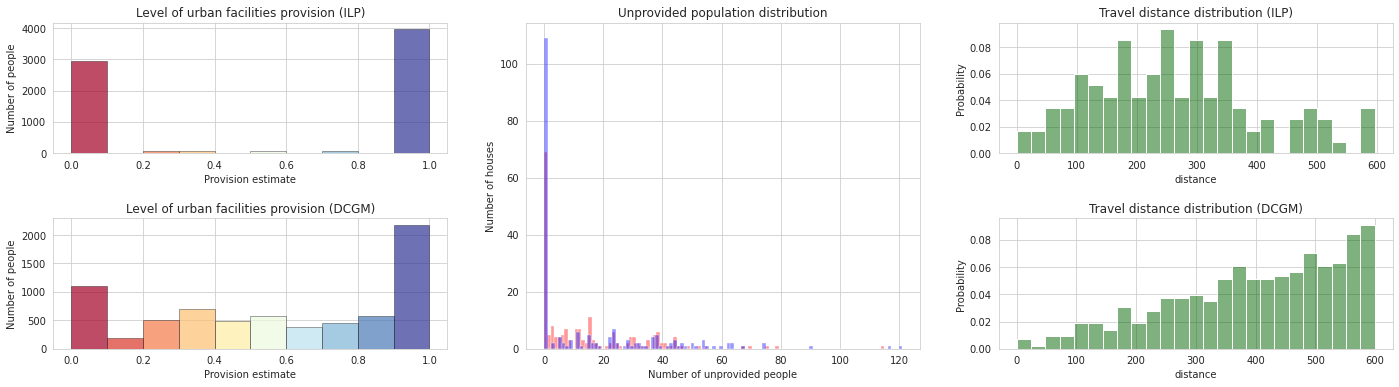

In [23]:
dist = 600
houses_loc = houses[houses["municipality_id"] == 87]

distances_ilp = DM[OD_ILP > 0][houses_loc.index].to_numpy().flatten()
distances_ilp = distances_ilp[~np.isnan(distances_ilp)]
flows_ilp = OD_ILP[OD_ILP > 0][houses_loc.index].to_numpy().flatten()
flows_ilp = flows_ilp[~np.isnan(flows_ilp)]

distances_dcgm = DM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
distances_dcgm = distances_dcgm[~np.isnan(distances_dcgm)]
flows_dcgm = OD_СDCGM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
flows_dcgm = flows_dcgm[~np.isnan(flows_dcgm)]

f_dist_dcgm = pd.DataFrame({"distance": distances_dcgm[distances_dcgm<=600], "flows":flows_dcgm[distances_dcgm<=600]})
f_dist_ilp = pd.DataFrame({"distance": distances_ilp[distances_ilp<=600], "flows":flows_ilp[distances_ilp<=600]})

fig = plt.figure(figsize=(24, 6))
plt.subplots_adjust(hspace=0.5)
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])
ax4 = fig.add_subplot(gs[0, 2])
ax5 = fig.add_subplot(gs[1, 2])

n, bins, patches = ax1.hist(houses_loc["provision_ilp"], 10, alpha = 0.7, weights=houses_loc["demand"], edgecolor='black', linewidth=0.5)
set_color_map(bins, patches, "RdYlBu")
n, bins, patches = ax2.hist(houses_loc["provision_dcgm"], 10, alpha = 0.7, weights=houses_loc["demand"], edgecolor='black', linewidth=0.5)
set_color_map(bins, patches, "RdYlBu")

sns.histplot(data=houses_loc["left_demand_dcgm"], kde=False, bins=100, color="red", alpha=0.4, ax=ax3)
sns.histplot(data=houses_loc["left_demand_ilp"], kde=False, bins=100, color="blue", alpha = 0.4, ax=ax3)

sns.histplot(data=f_dist_ilp, x="distance", bins=25, color="darkgreen", alpha = 0.5, ax=ax4, stat = "probability", kde=False)
sns.histplot(data=f_dist_dcgm, x="distance", bins=25, color="darkgreen", alpha = 0.5, ax=ax5, stat = "probability", kde=False)

ax1.set_title("Level of urban facilities provision (ILP)")
ax1.set_xlabel("Provision estimate")
ax1.set_ylabel("Number of people")
ax2.set_title("Level of urban facilities provision (DCGM)")
ax2.set_xlabel("Provision estimate")
ax2.set_ylabel("Number of people")
ax3.set_title("Unprovided population distribution")
ax3.set_ylabel("Number of houses")
ax3.set_xlabel("Number of unprovided people")
ax4.set_title("Travel distance distribution (ILP)")
ax5.set_title("Travel distance distribution (DCGM)")

plt.show()

In [106]:
diff = houses["left_demand_ilp"] - houses["left_demand_dcgm"]

dm = (DM <= dist)
demand_around = dm.progress_apply(lambda x: houses['demand'][dm.loc[facilities["capacity"][x].index].any()].sum())
sum_capacity = dm.progress_apply(lambda x: facilities["capacity"][x].sum())
ratio = sum_capacity / demand_around

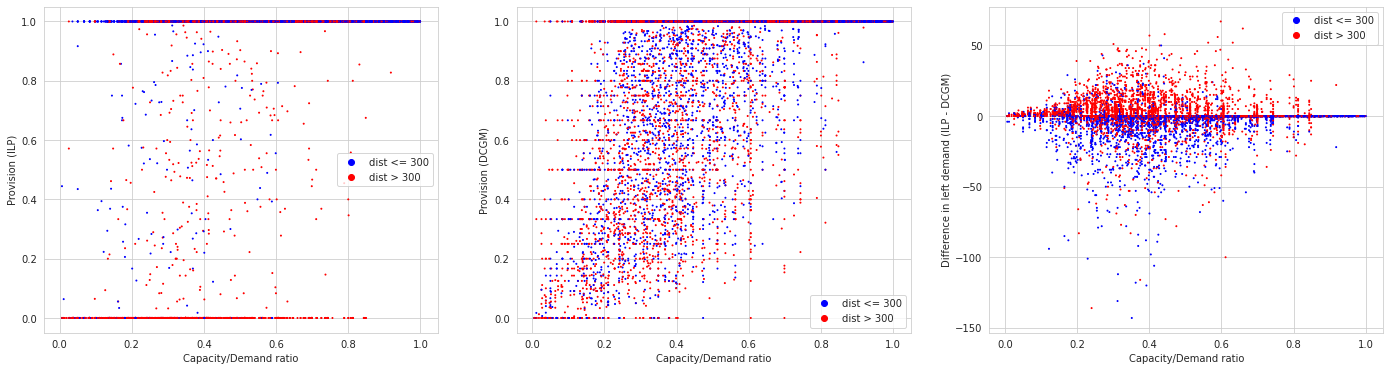

In [125]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
color_palette = ListedColormap(["b", "r"])
color_pointer = [0 if i <= 300 else 1 for i in list(DM.min()[ratio < 1])]
color_class = ["dist <= 300", "dist > 300"]

ax1.set_xlabel("Capacity/Demand ratio")
ax1.set_ylabel("Provision (ILP)")
a = ax1.scatter(ratio[ratio < 1], houses["provision_ilp"][ratio < 1], c=color_pointer, cmap=color_palette, s=1)
ax1.legend(handles=a.legend_elements()[0], labels=color_class)

ax2.set_xlabel("Capacity/Demand ratio")
ax2.set_ylabel("Provision (DCGM)")
b = ax2.scatter(ratio[ratio < 1], houses["provision_dcgm"][ratio < 1], c=color_pointer, cmap=color_palette, s=1)
ax2.legend(handles=b.legend_elements()[0], labels=color_class)

ax3.set_xlabel("Capacity/Demand ratio")
ax3.set_ylabel("Difference in left demand (ILP - DCGM)")
c = ax3.scatter(ratio[ratio < 1], diff[ratio < 1], c=color_pointer, cmap=color_palette, s=1)
ax3.legend(handles=c.legend_elements()[0], labels=color_class)